In [1]:
from pathlib import Path
import re, os, sys
import numpy as np
import matplotlib.pyplot as plt
import importlib
import roicat
from functools import reduce

import roi_tracking_helpers
importlib.reload(roi_tracking_helpers)
importlib.reload(roicat)


<module 'roicat' from '/home/athina/miniforge3/envs/roicat/lib/python3.12/site-packages/roicat/__init__.py'>

In [2]:
# Define paths and basic variables
basepath = Path('/media/mrsic_flogel/public/projects/AtApSuKuSaRe_20250129_HFScohort2')
animal = 'TAA0000059'
roicat_data_name = animal 
roicat_dir = Path(f'/media/mrsic_flogel/public/projects/AtApSuKuSaRe_20250129_HFScohort2/{roicat_data_name}/ROICaT')

# Choose sessions and paths for alignment
sessions_to_align = ['ses-008_date-20250321_protocol-t5', 'ses-009_date-20250323_protocol-t6']
# sessions_to_align = ['ses-005_date-20250218_protocol-t0',
#     'ses-006_date-20250224_protocol-t1',
#     'ses-007_date-20250304_protocol-t2',
#     'ses-008_date-20250306_protocol-t3',
#     'ses-010_date-20250314_protocol-t4',
#     'ses-011_date-20250315_protocol-t5',
#     'ses-012_date-20250318_protocol-t6',
#     'ses-013_date-20250320_protocol-t7',
#     'ses-014_date-20250326_protocol-t8',
#     'ses-015_date-20250327_protocol-t9',
#     'ses-016_date-20250330_protocol-t10',
#     'ses-017_date-20250331_protocol-t11',
#     'ses-018_date-20250403_protocol-t12',
#     'ses-019_date-20250404_protocol-t13',
#     'ses-020_date-20250412_protocol-t14',
#     'ses-021_date-20250426_protocol-t15',
#     'ses-022_date-20250509_protocol-t16',
#     'ses-023_date-20250516_protocol-t17']

protocol_nums = [int(re.search(r'protocol-t(\d+)', s).group(1)) for s in sessions_to_align]
protocol_nums = [protocol_nums[0], protocol_nums[-1]]

num_sessions = len(sessions_to_align)

alignment_dir = roicat_dir / 'alignment' / '_'.join(f't{n}' for n in protocol_nums)
print(alignment_dir)

/media/mrsic_flogel/public/projects/AtApSuKuSaRe_20250129_HFScohort2/TAA0000059/ROICaT/alignment/t5_t6


In [3]:
# Load ROICaT results
results = roi_tracking_helpers.load_roicat_results(roicat_dir, roicat_data_name)

In [4]:
# Get number of (valid) cells per session 
num_valid_neurons, num_neurons = roi_tracking_helpers.get_neuron_count(basepath, animal, sessions_to_align)
print(num_valid_neurons, num_neurons)

Loading iscell data for session ses-008_date-20250321_protocol-t5
Loading iscell data for session ses-009_date-20250323_protocol-t6
[273. 190.] [315. 222.]


#### Visualize ROICaT output


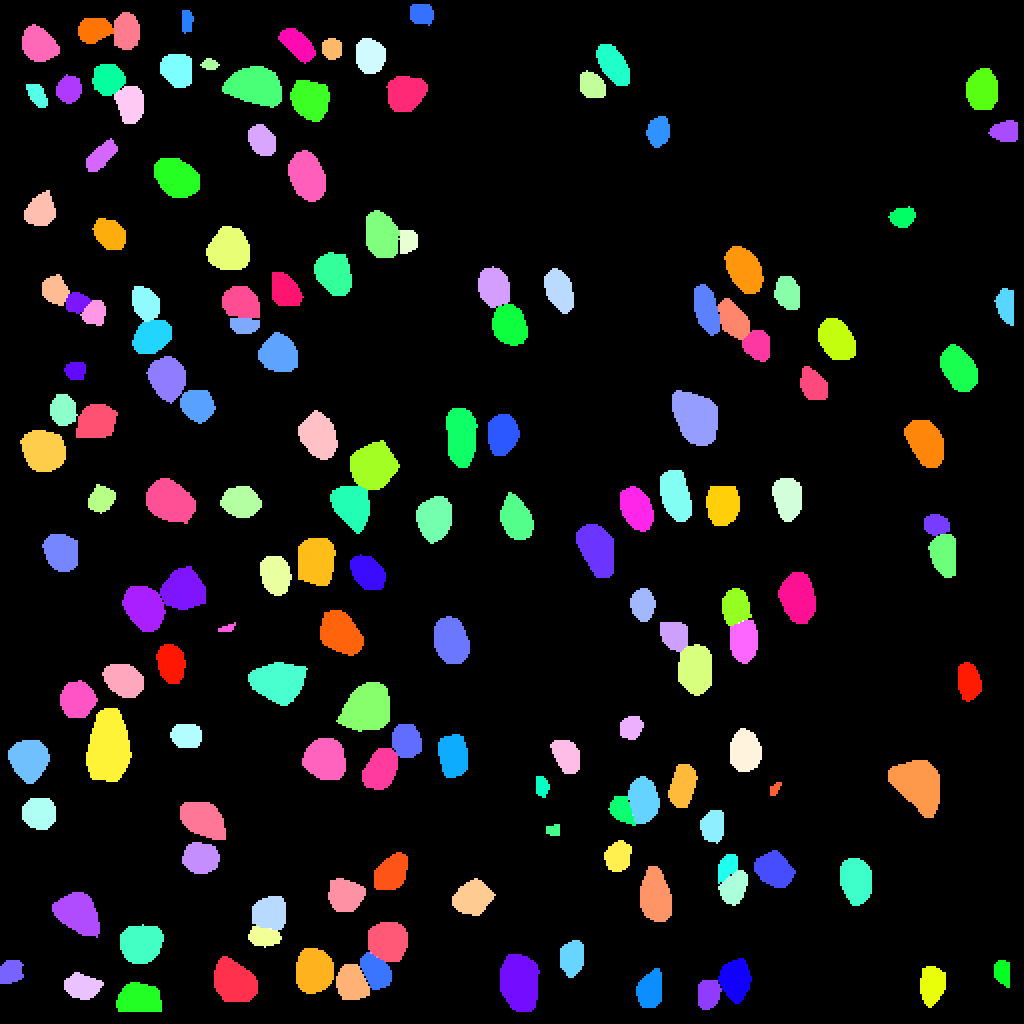

In [5]:
# Visualize ROICaT output 
roi_tracking_helpers.visualize_output(results, dir_save=roicat_dir, plot_metrics=False, \
                                      plot_clusters=False, plot_aligned_tracked_clusters=True)

#### Align clusters across sessions
After running ROICaT tracking, we are left with outputs we call 'labels' / 'UCIDs' (unique cluster IDs). These are unique integer ID numbers assigned that describe which cluster each ROI corresponds to across all sessions. Non-negative labels describe unique clusters, while '-1' specifically describes unclustered ROIs.

After alignment, we can extract idx_original_aligned with shape: (n_sessions, n_tracked_neurons). The **index** of an element for each row (session) in this array is the ROICaT tracking index / 'label' / 'UCID'. The **value** of that element corresponds to the suite2p label. We can thus use this value to directly extract the neural data for specific neurons from the suite2p output. 

In [6]:
# Load neural data (suite2p processed) 
# NOTE: might take ~1h to load depending on the computer and the number of sessions
data = roi_tracking_helpers.load_neural_data(basepath, animal, sessions_to_align, data_type='F')

Loading neural data for session ses-008_date-20250321_protocol-t5
Loading neural data for session ses-009_date-20250323_protocol-t6


In [14]:
# Align the neural data and the cluster IDs or load the data if already aligned
importlib.reload(roi_tracking_helpers)
importlib.reload(roicat)

_, idx_original_aligned = roi_tracking_helpers.align_rois(roicat_dir, roicat_data_name, sessions_to_align, \
                                                          basepath, animal, alignment_method='F', neural_data=data, \
                                                          roicat_results=None, plot_alignment=True, save_results=True, force_reload=False,\
                                                          alignment_dir=alignment_dir, filename=f'roicat_aligned_ROIs_{'_'.join(['t' + str(n) for n in protocol_nums])}.npy')

Aligned clusters already found. Loading...


#### Tracking metrics

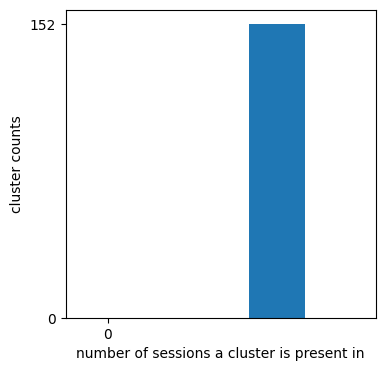

In [9]:
# Cluster persistence = how many session a cluster is present in
fig = roi_tracking_helpers.visualize_cluster_persistence(results)
fig.savefig(os.path.join(alignment_dir, 'cluster_persistence.png'))

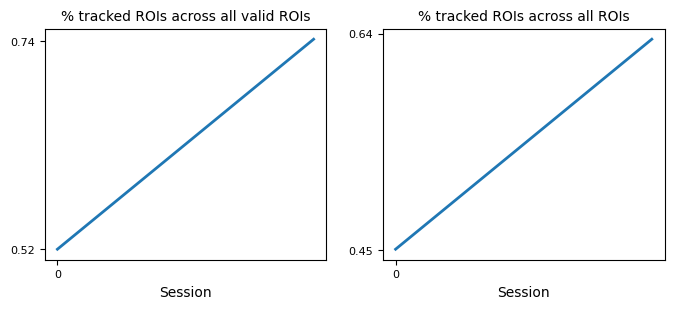

In [10]:
# Get the number of tracked clusters over all (valid) clusters per session 
fig = roi_tracking_helpers.visualize_tracked_clusters_per_session(idx_original_aligned, num_valid_neurons, num_neurons)
fig.savefig(os.path.join(alignment_dir, 'clusters_tracked_per_session.png'))

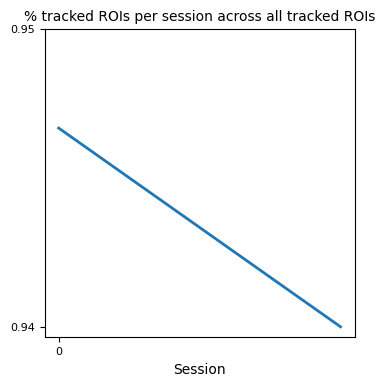

In [11]:
# Get the number of tracked clusters per session over all tracked clusters 
fig = roi_tracking_helpers.visualize_tracked_clusters_in_session(idx_original_aligned)
fig.savefig(os.path.join(alignment_dir, 'clusters_tracked_in_session.png'))

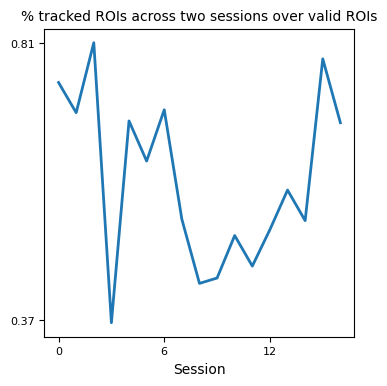

In [161]:
fig = roi_tracking_helpers.visualize_pairwise_cluster_persistence(idx_original_aligned, num_valid_neurons)
fig.savefig(os.path.join(alignment_dir, 'pairwise_cluster_persistence.png'))

#### Visualize ROIs


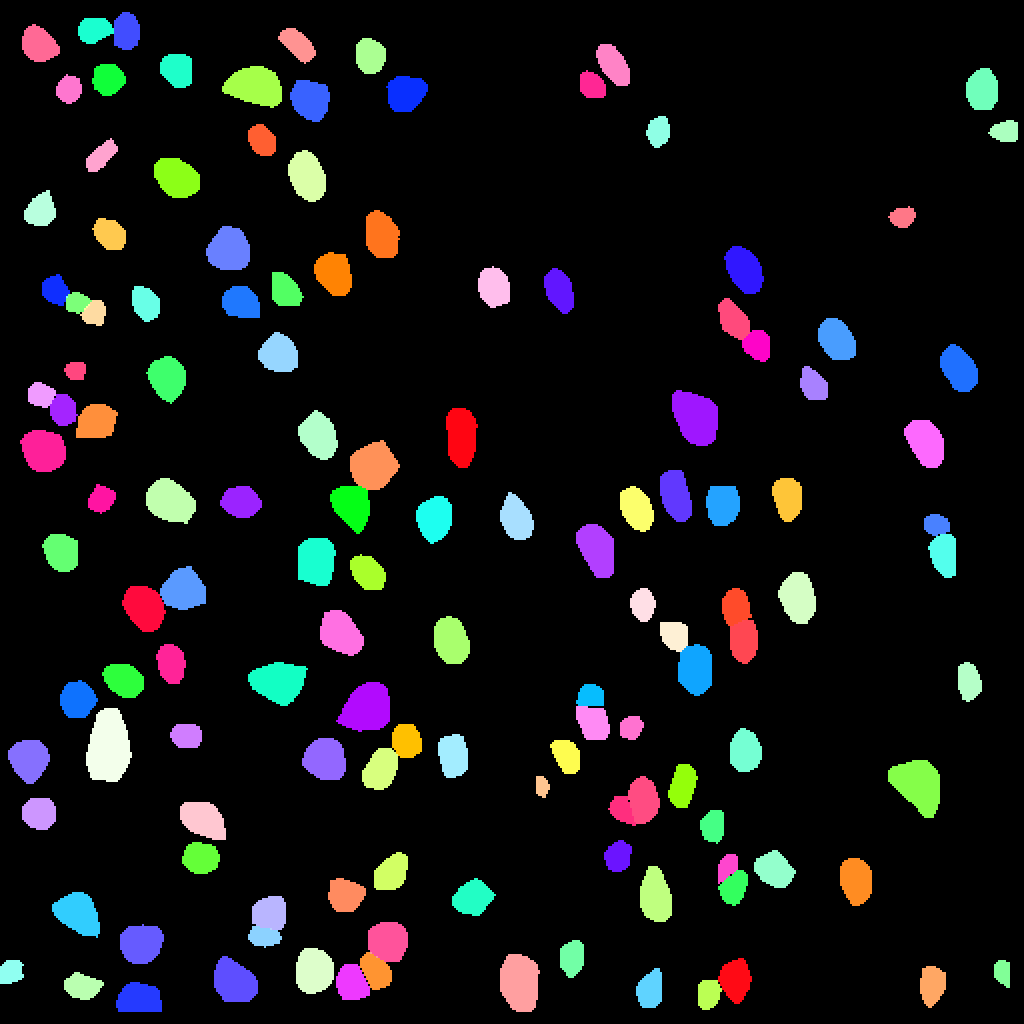

In [15]:
# Keep neurons that have been tracked in all sessions
idx_array = np.vstack(idx_original_aligned)  # shape: (n_sessions, n_neurons)
valid_mask = np.all(~np.isnan(idx_array), axis=0)  # Find neurons that are not nan in all sessions
valid_indices = np.where(valid_mask)[0]  # Get the indices that are valid across all sessions
tracked_neuron_ids = [session[valid_indices].astype(int) for session in idx_original_aligned]

# Visualize all tracked ROIs across sessions
roi_tracking_helpers.roicat_visualize_tracked_rois(roicat_dir, roicat_data_name, sessions_to_align, roicat_results=results, \
                                                   tracked_neuron_ids=tracked_neuron_ids, dir_save=roicat_dir, 
                                                   filename='tracked_all_sessions_FOV_clusters')

### Select specific data to visualize - ignore otherwise

In [ ]:
# T5 (4-goal) vs T8
data = np.load(os.path.join(roicat_dir, f'T5-T8_4-goal_progress_tracked_neurons.npz'))
tracked_neuron_ids = [np.array(data['t5_neurons'], dtype=int), np.array(data['t8_neurons'], dtype=int)]

roi_tracking_helpers.roicat_visualize_tracked_rois(roicat_dir, roicat_data_name, sessions_to_align=[sessions_to_align[5],sessions_to_align[8]], roicat_results=results, \
                                                   tracked_neuron_ids=tracked_neuron_ids, dir_save=roicat_dir, 
                                                   filename='tracked_t5-t8_4-goal_FOV_clusters')


FileNotFoundError: [Errno 2] No such file or directory: '/media/mrsic_flogel/public/projects/AtApSuKuSaRe_20250129_HFScohort2/TAA0000059/ROICaT/T5-T8_4-goal_progress_tracked_neurons.npz'